### Basic imports (TODO: move to a python file?)

In [6]:
import pickle


from diffusion.likelihood import mmff_energy


#from rdkit.Chem.Draw import IPythonConsole
#IPythonConsole.ipython_useSVG=True 
import py3Dmol


from rdkit import Chem, Geometry


#from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt


from rdkit.Chem import rdMolAlign 


#from termcolor import colored 
from rdkit.Chem import rdMolTransforms


from utils.standardization import fast_rmsd


from torch_geometric.data import Data, Batch


import tqdm 


from torch.utils.data import Subset 


import time 

#from diffusion.sampling import get_seed, embed_seeds

from utils.dataset import *
print('yay')

from gflownet.make_eval_plots import get_2dheatmap_array_and_pt 
print('yay')

from utils.torsion import get_rotatable_ta_list 
print('yay')

import pandas as pd
print('yay')



/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:99: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_spline_conv/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


yay
yay
yay
yay


In [1]:
def set_bond_lengths(mol, ref_mol):
    new_mol = copy.deepcopy(mol)
    assert new_mol.GetNumConformers() == 1    
    for bond in mol.GetBonds():
        if bond.IsInRing() == False:
            new_bond_length = rdMolTransforms.GetBondLength(ref_mol.GetConformer(),bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx() )
            rdMolTransforms.SetBondLength(new_mol.GetConformer(), bond.GetBeginAtom().GetIdx(), bond.GetEndAtom().GetIdx(), new_bond_length )
    return new_mol

def set_bond_angles(mol, ref_mol):
    new_mol = copy.deepcopy(mol)
    assert mol.GetNumConformers() == 1
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        for neighbor in atom2.GetNeighbors():
            if neighbor.GetIdx() != atom1.GetIdx():
                if not (atom1.IsInRing() and atom2.IsInRing() and neighbor.IsInRing() ):
                    new_angle = rdMolTransforms.GetAngleRad(ref_mol.GetConformer(),   
                                                        atom1.GetIdx(), 
                                                        atom2.GetIdx(), 
                                                        neighbor.GetIdx())
                    rdMolTransforms.SetAngleRad(new_mol.GetConformer(),   
                                                        atom1.GetIdx(), 
                                                        atom2.GetIdx(), 
                                                        neighbor.GetIdx(), new_angle)
    return new_mol

In [2]:
def plot_aligned_confs(mols):
    #for conf in data:
        #mol = pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True)
        #mols.append(mol)
    # align all mols to the first one
    for i in range(1, len(mols)):
        rdMolAlign.AlignMol(mols[i], mols[0])
    # Plot mols
    ## Convert to mol blocks
    mol_blocks = [Chem.MolToMolBlock(mol) for mol in mols]

    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'pink', 'brown', 'grey', 'black', 'white', 'salmon', 'olive', 'lime', 'teal', 'indigo', 'violet', 'tan', 'khaki', 'gold', 'coral', 'azure', 'lavender', 'orchid', 'plum', 'crimson', 'maroon', 'sienna', 'navy', 'skyblue', 'turquoise', 'aquamarine', 'mint', 'lime', 'chartreuse', 'olive', 'khaki', 'gold', 'coral', 'salmon', 'tomato', 'orangered', 'firebrick', 'maroon', 'sienna', 'chocolate', 'saddlebrown', 'brown', 'black', 'grey', 'dimgray', 'darkgray', 'silver', 'lightgray', 'gainsboro', 'white']
    view = py3Dmol.view(width=400, height=400)
    for i, mol_block in enumerate(mol_blocks):
        view.addModel(mol_block, "mol")
        view.setStyle({'model': i}, {'stick': {'color': colors[i%len(colors)]}})

    view.addLabel('confs',{'position': {'x': 0, 'y': 8, 'z': 0}, 
                'backgroundColor': 'white', 
                'fontColor': 'black', 
                'fontSize': 16, 
                'alignment': 'topCenter'})
    view.zoomTo()
    view.show()

In [3]:
def get_rmsd_torsiondist(data,ix0, ix1):
    '''
    Get 2D rmsd heatmap and 2D torsion_angles dists heatmap
    '''
    torsion_angles_linspace = torch.linspace(0, 2*np.pi, 100)
    rmsds = []
    torsion_angles_dists = []
    for theta0 in torsion_angles_linspace:
        rmsds.append([])
        torsion_angles_dists.append([])
        for theta1 in torsion_angles_linspace:
            data0 = copy.deepcopy(data)
            torsion_update = np.zeros(len(data0.mask_rotate))
            torsion_update[ix0], torsion_update[ix1] = theta0, theta1
            new_pos = modify_conformer(data0.pos, data0.edge_index.T[data0.edge_mask], data0.mask_rotate, torsion_update, as_numpy=False) #change the value of the 1st torsion angle
            data0.pos = new_pos
            mol0 = pyg_to_mol(data0.mol, data0, mmff=False, rmsd=True, copy=True)
            mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
            rmsds[-1].append(fast_rmsd(mol0, mol, conf1=0, conf2=0))
            torsion_angles_dists[-1].append(min(theta1, 2 * np.pi - theta1) + min(theta0, 2 * np.pi - theta0))  
            
    return rmsds, torsion_angles_dists

In [4]:
def embed_func(mol, numConfs):
    AllChem.EmbedMultipleConfs(mol, numConfs=numConfs, numThreads=5)
    return mol

In [5]:
def set_positions(mol, positions):
    new_mol = copy.deepcopy(mol)
    for atom_idx, pos in enumerate(positions):
        new_mol.GetConformer().SetAtomPosition(atom_idx, Geometry.Point3D(pos[0], pos[1], pos[2]))
    return new_mol

### Explore freesolv

In [8]:
freesolv_df = pd.read_csv('data/freesolv_79smis_1_confs.csv')
freesolv_df = freesolv_df[~freesolv_df['smiles'].isin([ ' c1cc(ccc1[N+](=O)[O-])O', ' CC[C@@H](C)CO' , ' C[C@@H](CO[N+](=O)[O-])O[N+](=O)[O-]' , ' CCCC[N+](=O)[O-]', ' CC(=O)CO[N+](=O)[O-]', ' Cc1cccc(c1)[N+](=O)[O-]', ' CC[N+](=O)[O-]', ' CCOP(=S)(OCC)S[C@@H](CCl)N1C(=O)c2ccccc2C1=O',
 ' CCOP(=S)(OCC)Oc1ccc(cc1)[N+](=O)[O-]',
 ' CCCC[N@](CC)c1c(cc(cc1[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]',
 ' CCOC(=O)C[C@H](C(=O)OCC)SP(=S)(OC)OC',
 ' CCN(CC)c1c(cc(c(c1[N+](=O)[O-])N)C(F)(F)F)[N+](=O)[O-]',
 ' CCCN(CCC)c1c(cc(cc1[N+](=O)[O-])S(=O)(=O)C)[N+](=O)[O-]',
 ' CCCN(CCC)c1c(cc(cc1[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]'
 ])]
# remove some smiles cause they don't have md simulation
limit_mols = 72
smis_train, smis_test = list(set(freesolv_df['smiles'].tolist()))[:limit_mols], list(set(freesolv_df['smiles'].tolist()))[limit_mols:]
smis_train, smis_test = [x[1:] for x in smis_train], [x[1:] for x in smis_test] # Remove the first empty space in the smiles names
print('len of dataset, ' , len(smis_train), len(smis_test))

len of dataset,  72 0


In [9]:
' '.join(smis_train)

'CC(C)C=C COc1ccccc1 CCCCCBr CCOC(=O)c1ccc(cc1)O CC(C)CO CC(C)O CCOP(=S)(OCC)SCSCC CC=C(C)C CCCCCCBr CCOC(=O)c1ccccc1 COc1cccc(c1O)OC COC(OC)OC CCCCC(=O)OCC CC(C)(C)C(=O)OC CCC[C@@H](C)O CC(C)OC(C)C COc1ccccc1N CCCCCCCCC=O CC(=CCC/C(=C/CO)/C)C CCCCCCl CC[C@H](C)c1ccccc1 CCCCCCCC(=O)C CCOC(=O)CCC(=O)OCC CC(C)COC(=O)C CC[C@H](C)O CC(=C)C=C CCSC CC(=O)OCC(COC(=O)C)OC(=O)C CC(C)CCO CC[C@H](C(C)C)O CCCc1ccc(c(c1)OC)O CCCCCCCC(=O)OC CC(=CCC/C(=C\\CO)/C)C Cn1cnc2c1c(=O)n(c(=O)n2C)C Cc1cccc(c1C)O C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl COc1ccccc1OC CC(C)(C)Br CC(C)CCOC=O Cc1cc2ccccc2cc1C C1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O CCCCC=O CCCc1ccccc1 CC(C)c1ccccc1 CCCCCCN CCCOCCC C[C@@H]1CCCC[C@@H]1C CC(=C)c1ccccc1 CCc1cccc(c1)O C([C@H]([C@H]([C@@H]([C@@H](CO)O)O)O)O)O CCOP(=O)(OCC)OCC CC(=O)Oc1ccccc1C(=O)O CCc1cccc2c1cccc2 c1ccc2c(c1)C(=O)c3c(ccc(c3C2=O)N)N c1ccc(c(c1)C(F)(F)F)C(F)(F)F CCCCOCCCC CC(C)(/C=N\\OC(=O)NC)SC COCC(OC)(OC)OC CN(C)C(=O)Nc1ccccc1 CCCC(C)(C)C c1cc(cc(c1)O)C#N CCOCCO c1cc

In [9]:
def get_info(smis):
    num_heavy_atoms = [] 
    num_atoms = [] 
    num_torsion_angles = [] 
    valid_smis = []
    min_n_torsion = 1
    for smi in tqdm.tqdm(smis): 
        mol, data = get_seed(smi)
        if mol is None:
            pass
        #elif hasattr(data, 'mask_rotate') == False or data.mask_rotate.shape[0] < min_n_torsion:
        elif len(get_rotatable_ta_list(mol)) < min_n_torsion:
                pass
        else:
            num_heavy_atoms.append(mol.GetNumHeavyAtoms())
            num_atoms.append(mol.GetNumAtoms())
            num_torsion_angles.append(len(get_rotatable_ta_list(mol)))
            valid_smis.append(smi)

    num_heavy_atoms, num_atoms, num_torsion_angles = np.array(num_heavy_atoms), np.array(num_atoms), np.array(num_torsion_angles)
    valid_smis = np.array(valid_smis)
    print(f'Processable smiles: {len(valid_smis)} out of {len(smis)}')
    return num_heavy_atoms, num_atoms, num_torsion_angles, valid_smis


num_heavy_atoms, num_atoms, num_torsion_angles, valid_smis = get_info(smis_train)
smis_with_2_tas = np.array(valid_smis)[np.where(num_torsion_angles == 2)]



  0%|          | 0/72 [00:00<?, ?it/s]

100%|██████████| 72/72 [00:00<00:00, 189.46it/s]

Processable smiles: 72 out of 72


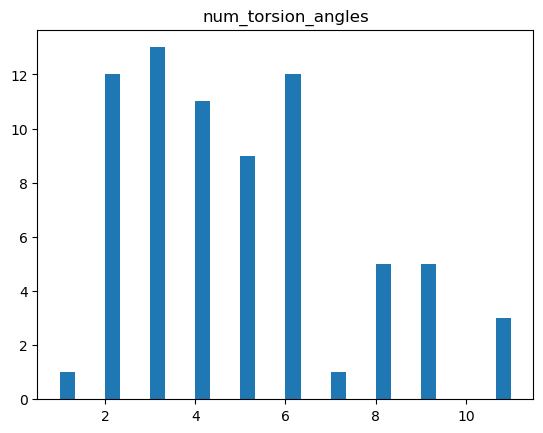

In [10]:
plt.hist(num_torsion_angles, bins=30)
plt.title("num_torsion_angles")
plt.show()

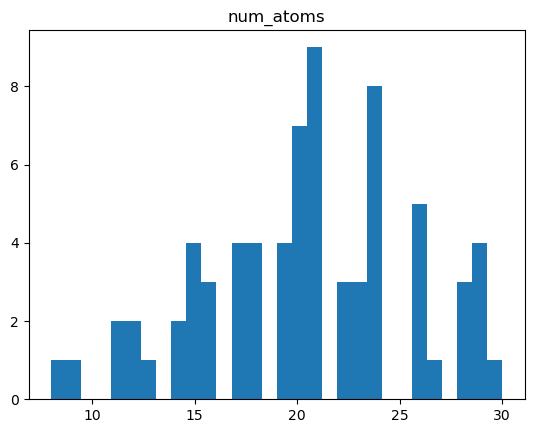

In [11]:
plt.hist(num_atoms, bins=30)
plt.title("num_atoms")
plt.show()

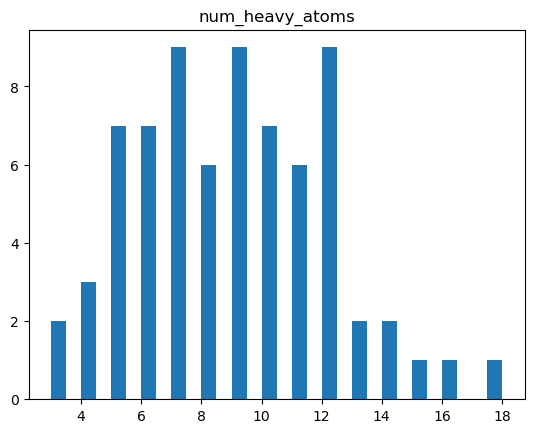

In [12]:
plt.hist(num_heavy_atoms, bins=30)
plt.title("num_heavy_atoms")
plt.show()

In [13]:
'''
k_b = 0.001987204118 
room_temp = 298.15
T = k_b * room_temp

md_trajs_dict = pickle.load(open('/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/mdtrajs_dict_reordered.pkl', 'rb'))
not_valid_smis = []
pos_md = {key[1:]: value for  key, value in md_trajs_dict.items()}
logrews_md = {key[1:]: [] for  key, value in md_trajs_dict.items()}
mols_md  = {key[1:]: [] for  key, value in md_trajs_dict.items()}
for smi in tqdm.tqdm(list(mols_md.keys())):
    try:
        mol, data = get_seed(smi)
        AllChem.EmbedMultipleConfs(mol, numConfs=1)
        try: 
            for i in range(len(pos_md[smi])):
                pos = pos_md[smi][i]
                assert len(10 * pos.astype('double')) == mol.GetNumAtoms()
                new_mol = set_positions(mol,10 * pos.astype('double'))
                mols_md[smi].append(new_mol) 
                logrews_md[smi].append( - mmff_energy(new_mol) / T)
        except:
            print('error')
    except:
        print('smi ', smi)
        not_valid_smis.append(smi)

for smi in  not_valid_smis:
    del logrews_md[smi]
    del mols_md[smi]
    del pos_md[smi]
    
pickle.dump(logrews_md, open('data/logrews_md.pkl', 'wb'))
pickle.dump(mols_md, open('data/mols_md.pkl', 'wb'))
pickle.dump(pos_md, open('data/pos_md.pkl', 'wb'))
'''

"\nk_b = 0.001987204118 \nroom_temp = 298.15\nT = k_b * room_temp\n\nmd_trajs_dict = pickle.load(open('/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/mdtrajs_dict_reordered.pkl', 'rb'))\nnot_valid_smis = []\npos_md = {key[1:]: value for  key, value in md_trajs_dict.items()}\nlogrews_md = {key[1:]: [] for  key, value in md_trajs_dict.items()}\nmols_md  = {key[1:]: [] for  key, value in md_trajs_dict.items()}\nfor smi in tqdm.tqdm(list(mols_md.keys())):\n    try:\n        mol, data = get_seed(smi)\n        AllChem.EmbedMultipleConfs(mol, numConfs=1)\n        try: \n            for i in range(len(pos_md[smi])):\n                pos = pos_md[smi][i]\n                assert len(10 * pos.astype('double')) == mol.GetNumAtoms()\n                new_mol = set_positions(mol,10 * pos.astype('double'))\n                mols_md[smi].append(new_mol) \n                logrews_md[smi].append( - mmff_energy(new_mol) / T)\n        except:\n            print('error')\n    except:\n     

In [14]:
smis = " CCS  C1C=CC[C@@H]2[C@@H]1C(=O)N(C2=O)SC(Cl)(Cl)Cl  COc1ccccc1  CC(=C)c1ccccc1  CCc1cccc2c1cccc2 ".split()
for smi in smis:
    if smi not in pos_md.keys():
        print(smi)  
   

NameError: name 'pos_md' is not defined

### FreeSolv eval plots

In this section, we define functions for making a histogram of energies, tica plots, and histograms distribution of bond lengths/bond angles/torsion angles/ visualizing energy plots vs logpT plots

In [15]:
## general model params
device = torch.device('cuda')
sigma_min = 0.01 * np.pi
sigma_max = np.pi
## energy params
energy_fn = 'mmff'
seed = 0
k_b = 0.001987204118 
room_temp = 298.15
T = k_b * room_temp
logrew_clamp = -1e5
n_smis_batch = 1
energy_fn, seed, p_replay, p_expl, diffusion_steps, batch_size = 'mmff', 0, 0.0, 0.2, 20, 1024 
smis = " COc1ccccc1".split()
limit_train_mols = 1
max_n_local_structures = 1
train_mode = 'gflownet'


In [16]:
from gflownet.make_eval_plots import *


exp_path = f"{train_mode}_{energy_fn}_{seed}_limit_train_mols_{limit_train_mols}_p_replay_{p_replay}_p_expl_{p_expl}_diffusion_steps_{diffusion_steps}_max_n_local_structures_{max_n_local_structures}"
if limit_train_mols == 1 : 
    exp_path += f"_smi_{' ' + smis[0]}" 
model = load_model(exp_path, device)



generated_stuff = generate_stuff(model, smis, n_smis_batch, batch_size, diffusion_steps, T, logrew_clamp, energy_fn,device, sigma_min, sigma_max)
torch.cuda.empty_cache()


/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/mila/l/lena-nehale.ezzine/.conda/envs/torsional_diffusion/lib/python3.9/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type anno

smis subset ['COc1ccccc1']
logZ tensor([-55.2427], device='cuda:0')
logZs_hat [tensor([-55.2427], device='cuda:0')]
###################


In [17]:
make_logrew_histograms(generated_stuff, exp_path, label = 'train', range = 2)

In [18]:
## distribution of bond lengths/bond angles / torsion angles for generated, ground truth and random conformers
make_localstructures_histograms(generated_stuff, exp_path, label = 'train')


Smi COc1ccccc1


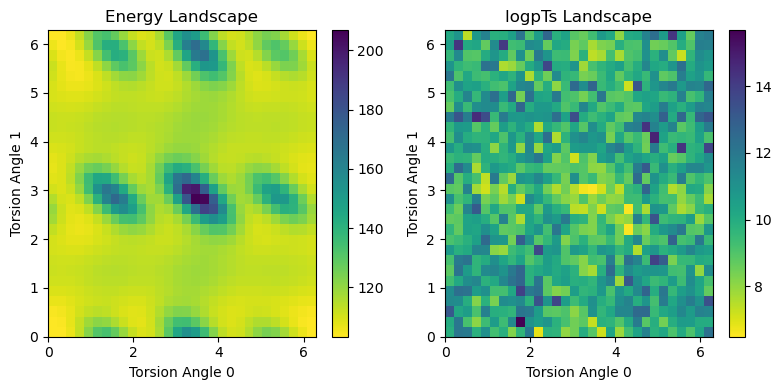

In [19]:
# Visualize the logpTs landscape vs the ground truth energy for a molecule with 2 torsion angles
import itertools
steps = 20
num_points = 30
num_trajs = 16
for smi in smis:
    print('Smi', smi)
    data = make_dataset_from_smi([smi], init_positions_path= "/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/md_trajs_dict.pkl" , n_local_structures = 1, max_n_local_structures=1)[0][0]
    num_torsion_angles = len(data.mask_rotate)
    for ix0, ix1 in itertools.combinations(range(num_torsion_angles), 2):
        energy_landscape, logpTs = get_2dheatmap_array_and_pt(data, model, sigma_min, sigma_max,  steps, device, num_points, ix0 = ix0, ix1 = ix1, energy_fn = energy_fn, ode = False, num_trajs = num_trajs, T = T  , get_pt = True)


        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        # Plot energy landscape
        ax[0].imshow(np.array(energy_landscape).transpose() / T, extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r', vmin=np.min(energy_landscape) / T, vmax=np.max(energy_landscape) / T)
        ax[0].set_title('Energy Landscape')
        ax[0].set_xlabel(f'Torsion Angle {ix0}')
        ax[0].set_ylabel(f'Torsion Angle {ix1}')
        fig.colorbar(ax[0].images[0], ax=ax[0], orientation='vertical')
        
        # Plot logpTs
        ax[1].imshow(np.array(logpTs).transpose(), extent=[0, 2 * np.pi, 0, 2 * np.pi], origin='lower', aspect='auto', cmap='viridis_r', vmin=np.min(logpTs), vmax=np.max(logpTs))
        ax[1].set_title('logpTs Landscape')
        ax[1].set_xlabel(f'Torsion Angle {ix0}')
        ax[1].set_ylabel(f'Torsion Angle {ix1}')
        fig.colorbar(ax[1].images[0], ax=ax[1], orientation='vertical')
        plt.tight_layout()
        plt.show()

array([[1.        , 0.38970308],
       [0.38970308, 1.        ]])

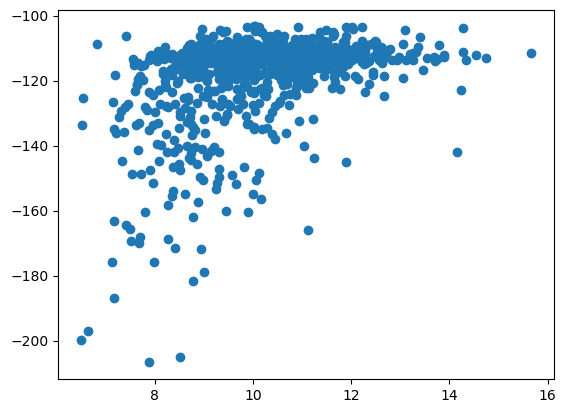

In [20]:
logpTs , energy_landscape = np.array(logpTs).flatten(), np.array(energy_landscape).flatten()

ixs = np.where( - (energy_landscape  / T )> - np.inf)
plt.scatter( logpTs[ixs[0]], -  energy_landscape[ixs[0]] / T)
np.corrcoef(logpTs[ixs[0]], -  energy_landscape[ixs[0]] / T)

In [ ]:
# plot elements from the replay buffer 
replaybuffer_path = '/home/mila/l/lena-nehale.ezzine/scratch/torsionalGFN/replay_buffer'
replaybuffer = pickle.load(open(f'{replaybuffer_path}/{exp_path}.pkl', 'rb'))
replaybuffer

In [ ]:
md_confs = make_dataset_from_smi(smis, init_positions_path= "/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/md_trajs_dict.pkl" , n_local_structures = 10)
md_confs = {smi: item for smi,item in zip(smis, md_confs)}
get_correlations(md_confs, model, T, sigma_min, sigma_max,  diffusion_steps, device, num_trajs = 32, energy_fn = energy_fn, logrew_clamp  = logrew_clamp , exp_path = exp_path, n_subplots = 5)

### Euclidean RMSD vs torsional RMSD

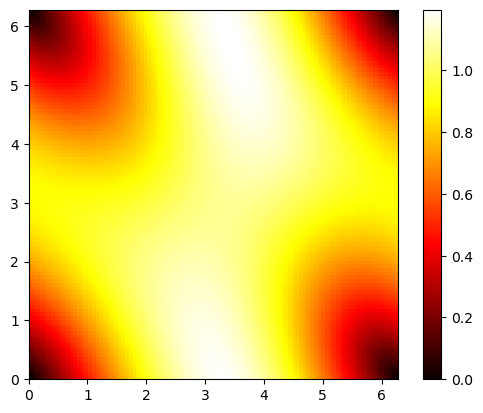

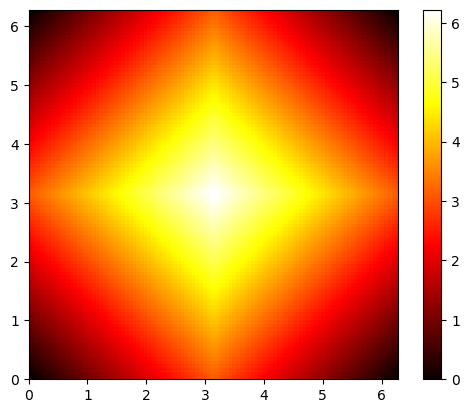

In [31]:
smi =  'COc1ccccc1'
data = make_dataset_from_smi([smi], init_positions_path= "/home/mila/l/lena-nehale.ezzine/ai4mols/torsional-diffusion/data/md_trajs_dict.pkl" , n_local_structures = 1)[0][0]
rmsds,torsion_angles_dists  = get_rmsd_torsiondist(data , ix0 = 0, ix1 = 1)
plt.figure() 
plt.imshow(rmsds, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()
plt.figure()
plt.imshow(torsion_angles_dists, extent=(0, 2*np.pi, 0, 2*np.pi), origin='lower', cmap='hot', interpolation='nearest')
plt.colorbar()

### Distributional shift(ground truth/ rdkit-generated data/ rdkit-generated data after confs matching) in bond lengths/bond angles 

In [25]:
ix_smi = 0
datapoint = dataset.datapoints[ix_smi]
data = copy.deepcopy(datapoint)
mols = []
for ix in range(len(data.pos)):
    data.pos, data.weights = datapoint.pos[ix], datapoint.weights[ix]
    mol = pyg_to_mol(data.mol, data, mmff=False, rmsd=True, copy=True)
    mols.append(mol)

get_stds_internal_coords(mols)

(tensor(0.0150), tensor(0.0328), tensor(1.5765))

In [9]:
mols_gen = list(conformers_gen.values())[0]
get_stds_internal_coords(mols_gen)

(tensor(0.0159), tensor(0.0701), tensor(1.5332))

In [10]:
bond_angles = [get_bond_angles(mol) for mol in mols]
bond_angles_gen = [get_bond_angles(mol)[:-1] for mol in mols_gen]
torch.stack(bond_angles + bond_angles_gen).std(dim=0).mean()

tensor(0.1286)

In [11]:
bond_lengths = [get_bond_lengths(mol) for mol in mols]
bond_lengths_gen = [get_bond_lengths(mol) for mol in mols_gen]
torch.stack(bond_lengths + bond_lengths_gen).std(dim=0).mean()

tensor(0.0986)

Hm, the std deviation of bond lengths&bond angles increases when we concatenate [mols_ground truth, mols_gen]. which seems to indicate a distributional shift in the lengths/angles distributions when we are moving from gt to rdkit-generated. Does this explain the energy-shifts?

Hmmmm, interesting, the torsion angles change a lot with relaxation. But why does relaxation need to go so far in terms of RMSD? Why doesn't it go to the closest 'ground-truth' conformer?

Well, if we look at the eval metrics for this set of molecules: 

 - threshold 0.75:

- Recall Coverage: Mean = 61.66, Median = 82.02

- Recall AMR: Mean = 0.6300, Median = 0.5793

- Precision Coverage: Mean = 35.80, Median = 42.31

- Precision AMR: Mean = 0.9013, Median = 0.7905

The precision AMR is around 0.9, i.e. it is the same order of magnitude of relaxtion. So the results with relaxation are not that surprising


**Training conformers after conformer matching have low energy!** Ca laisse penser que c'est le modele qui est pas assez bon

        - Plot : bond lengths and angles distribution of training conformers after confs matching. Ot has very low variance, so it makes sense to fix bond lengths/angles, and it's the diff model that is pretty bad
       
        - How does this energy compare to the energy of conformers **before confs matching?** -> voir si ça vaut vraiment le coup de fixer les bond lengths/angles ou pas

### Impact of fixing the bond lengths/angles on the energy

In [ ]:
import random

all_energies_before = []
all_energies_after = []

for smi_idx in tqdm(range(len(dataset))): 
#random.sample(range(0, len(dataset)), n_smis)
#for smi_idx in range(0, n_smis):   
    confs = get_gt_confs(dataset, smi_idx)
    mols = [pyg_to_mol(conf.mol, conf, mmff=False, rmsd=False, copy=True) for conf in confs]
    energies_before = [mmff_energy(mol) for mol in mols]
    energies_after = []
    for mol in mols:
        mol = set_bond_lengths(mol, mols[-1])
        mol = set_bond_angles(mol, mols[-1])
        energies_after.append(mmff_energy(mol))
    all_energies_before.append(energies_before)
    all_energies_after.append(energies_after)


100%|██████████| 9295/9295 [13:56<00:00, 11.12it/s]


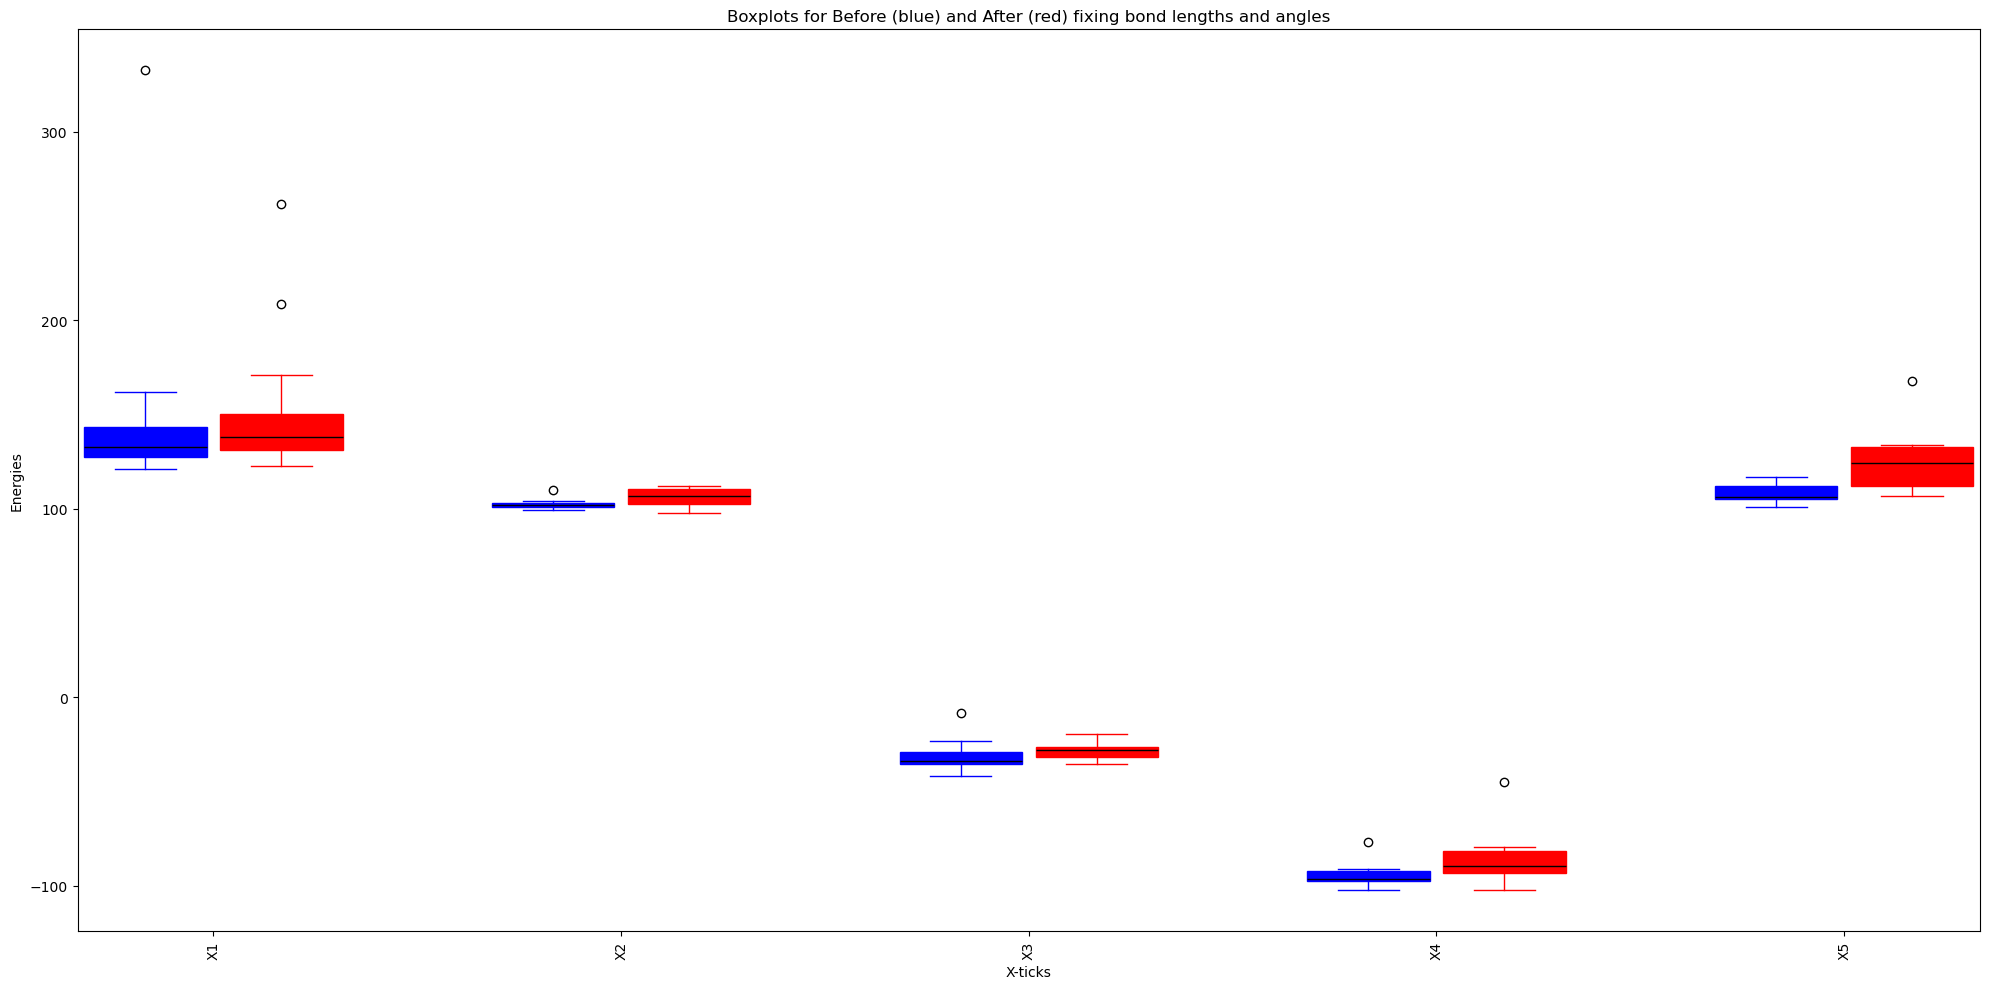

In [ ]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))
n_smis = 5
# Plot the boxplots
positions = np.arange(1, 3* n_smis + 1, 3)  # Positions for 'before' boxplots
for i in range(n_smis):
    ax.boxplot(all_energies_before[i], positions=[positions[i]], widths=0.9,  patch_artist=True,
               boxprops=dict(facecolor='blue', color='blue'),
               medianprops=dict(color='black'),
               whiskerprops=dict(color='blue'),
               capprops=dict(color='blue'))

    ax.boxplot(all_energies_after[i], positions=[positions[i ] + 1], widths=0.9, patch_artist=True,
               boxprops=dict(facecolor='red', color='red'),
               medianprops=dict(color='black'),
               whiskerprops=dict(color='red'),
               capprops=dict(color='red'))

# Customize x-ticks
ax.set_xticks(positions + 0.5)
ax.set_xticklabels([f'X{i+1}' for i in range(n_smis)], rotation=90)

# Set labels and title
ax.set_xlabel('X-ticks')
ax.set_ylabel('Energies')
ax.set_title('Boxplots for Before (blue) and After (red) fixing bond lengths and angles')
# Display the plot
plt.tight_layout()
plt.show()

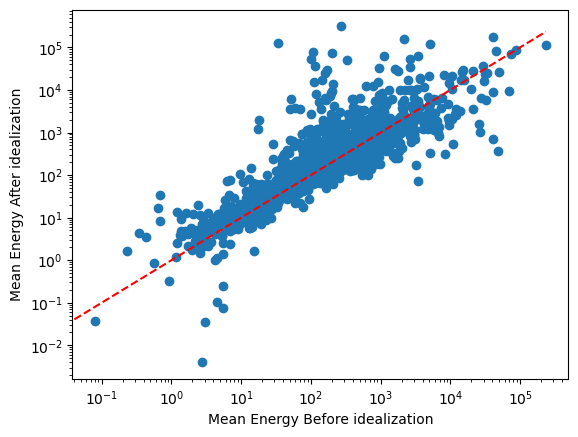

In [ ]:
energies_before_means = [np.mean(x) for x in all_energies_before]
energies_after_means = [np.mean(x) for x in all_energies_after]

plt.scatter(energies_before_means, energies_after_means)
plt.xlabel('Mean Energy Before idealization')
plt.ylabel('Mean Energy After idealization')
plt.xscale('log')

plt.plot([min(energies_before_means), max(energies_before_means)], 
         [min(energies_before_means), max(energies_before_means)], 
         color='red', linestyle='--')
plt.yscale('log')
plt.show()


TODO: after the deadline, look into outliers of this plot